## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
#from torcheval.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import warnings
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, multilabel_confusion_matrix


from utils_text_processing import *

/home/aurelie/anaconda3/envs/abes_index/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-05 18:25:45.590741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 18:25:46.349095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-05 18:25:47.576303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/

gensim version: 4.3.1
tensorflow version: 2.12.0
Num GPUs Available:  0
is tf built with cuda: True


[nltk_data] Downloading package words to /home/aurelie/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aurelie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/aurelie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


USE model %s loaded


https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
https://www.youtube.com/watch?v=vNKIg8rXK6w&ab_channel=rupertai


In [2]:
torch.set_float32_matmul_precision('high')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
!nvidia-smi

/bin/bash: /home/aurelie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Apr  5 18:25:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0  On |                  Off |
|  0%   42C    P8    26W / 450W |      3MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-

In [5]:
torch.manual_seed(42)

In [6]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figures"

In [7]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Create Dataset

In [8]:
# Import data
df = pd.read_csv(os.path.join(data_path, 'working_data_rameau.csv'), index_col=0)
print(df.shape)
df.head()

(89416, 11)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,DDC,TEF_LABEL,test_tiret,rameau_list,rameau_list_unstack
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,840.0,Littérature de langues romanes. Littérature fr...,False,['Culture populaire;Diffusion de la culture;Po...,"['Culture populaire', 'Diffusion de la culture..."
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",150.0,Psychologie,False,['Complexe de castration;Psychanalyse;Rêves'],"['Complexe de castration', 'Psychanalyse', 'Rê..."
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",840.0,Littérature de langues romanes. Littérature fr...,False,['Culture'],['Culture']
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",100.0,"Philosophie, psychologie",False,['Structuralisme'],['Structuralisme']
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,830.0,Littérature allemande,True,['Science-fiction américaine -- Traductions fr...,"['Science-fiction américaine', 'Traductions fr..."


In [9]:
# Transform rameau_list_unstack variable
eval(df.loc[1, "rameau_list_unstack"])
df["target"] = df["rameau_list_unstack"].apply(lambda x: eval(x))
df["target"]

0        [Culture populaire, Diffusion de la culture, P...
1            [Complexe de castration, Psychanalyse, Rêves]
2                                                [Culture]
3                                         [Structuralisme]
4        [Science-fiction américaine, Traductions franç...
                               ...                        
89411                       [Humanité, Réalisation de soi]
89412    [Aliments, Ouvrages pour la jeunesse, Pois (lé...
89413                        [Représentation du personnel]
89414    [Droit pénal, Sécurité sociale, Droit, Disposi...
89415    [Fraude scientifique, Lutte contre, Médecins, ...
Name: target, Length: 89416, dtype: object

In [10]:
# Convert the categorical labels to Multi Label Encodings
mlb = MultiLabelBinarizer()
df_multilabel= pd.DataFrame(mlb.fit_transform(df["target"]), columns=mlb.classes_)
df_multilabel["descr"] = df["DESCR"]

In [11]:
len(mlb.classes_)

21374

In [12]:
# Split data
train_df, val_df = train_test_split(df_multilabel, test_size=0.33, random_state=42)

In [13]:
# Check sizes
print(f"train dataset size: {train_df.shape}")
print(f"test dataset size: {val_df.shape}")

train dataset size: (59908, 21375)
test dataset size: (29508, 21375)


In [14]:
# Verification des classes
print(f"There are {len(mlb.classes_)} different Rameau PPN")
mlb.classes_

There are 21374 different Rameau PPN


array(["'Ndrangheta",
       '10 et 11 janvier 2015, Manifestations des (France)',
       '11 septembre 2001, Attentats du (États-Unis)', ...,
       'Îlot thermique urbain', 'économie', 'éthique'], dtype=object)

In [15]:
# get one row
sample_row = df_multilabel.iloc[16]
sample_descr = sample_row.descr
sample_labels = sample_row[mlb.classes_]

print(sample_descr)
print()
print(sample_labels.to_dict())

La théorie des jeux et ses applications à l'économie mathématique La théorie des jeux occupe au sein des mathématiques de la décision une place prépondérante. Point de domaine de la recherche opérationnelle, du contrôle optimal ou de l'économie mathématique où elle ne fasse sentir son influence. C'est qu'en dépit de ses imperfections, elle reste le seul moyen rigoureux et formalisé d'appréhender les situations de conflit. Cet ouvrage donne une vue synthétique et concise de la théorie et s'oriente très rapidement vers ses applications à l'économie mathématique. C'est le fruit d'un enseignement pluridisciplinaire de plusieurs années à l'Université de Paris IX-Dauphine. On y trouvera aussi bien des exemples élémentaires destinés à faire comprendre la signification économique des concepts mis en oeuvre, que des théorèmes difficiles, destinés à montrer leur fécondité mathématique

{"'Ndrangheta": 0, '10 et 11 janvier 2015, Manifestations des (France)': 0, '11 septembre 2001, Attentats du (É

## Build the model

In [16]:
# Build Deep Learning Model with BERT/PyTorch
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)


In [17]:
encoding = tokenizer.encode_plus(
    sample_descr,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
)

In [18]:
# Check model
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [20]:
tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20]

['[CLS]',
 'La',
 'th',
 '##é',
 '##ori',
 '##e',
 'des',
 'j',
 '##eux',
 'et',
 'se',
 '##s',
 'applications',
 'à',
 'l',
 "'",
 'é',
 '##con',
 '##omi',
 '##e']

In [21]:
class RameauLabelDataset(Dataset):

    def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        desc = data_row.descr
        labels = data_row[mlb.classes_]

        encoding = self.tokenizer.encode_plus(
            desc,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return dict(
            desc = desc,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )

In [22]:
# Build dataset
train_dataset = RameauLabelDataset(df_multilabel, tokenizer)

In [23]:
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['desc', 'input_ids', 'attention_mask', 'labels'])

In [24]:
sample_item["desc"]

"La culture pour vivre Mort de la culture populaire en France. Mutation des institutions culturelles grâce à une technique de mise en relation des oeuvres et d'un public, et qui tend à créer un comportement culturel adapté aux caractéristiques de l'époque"

In [25]:
sample_item["labels"].shape

torch.Size([21374])

In [26]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 128]), torch.Size([8, 128]))

In [28]:
prediction = bert_model(sample_item['input_ids'].unsqueeze(dim=0), sample_item["attention_mask"].unsqueeze(dim=0))
prediction.last_hidden_state.shape, prediction.pooler_output.shape

(torch.Size([1, 128, 768]), torch.Size([1, 768]))

In [29]:
class RameauLabelDataModule(pl.LightningDataModule):

    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = RameauLabelDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )

        self.test_dataset = RameauLabelDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )

In [30]:
data_module = RameauLabelDataModule(train_df, val_df, tokenizer)
data_module.setup()

In [31]:
N_EPOCHS = 10
BATCH_SIZE = 12

In [32]:
class RameauLabelTagger(pl.LightningModule):
  
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
    self.training_step_outputs = []
  
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.training_step_outputs.append(loss)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": batch["labels"]}
  
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": batch["labels"]}
  
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return outputs
  
  # def on_train_epoch_end(self):
  #   labels = []
  #   predictions = []
  #   for output in outputs:
  #     for out_labels in output["labels"].detach().cpu():
  #       labels.append(out_labels)
  #     for out_predictions in output["predictions"].detach().cpu():
  #       predictions.append(out_predictions)
  #   labels = torch.stack(labels).int()
  #   predictions = torch.stack(predictions)
  #   for i, name in enumerate(LABEL_COLUMNS):
  #     class_roc_auc = auroc(predictions[:, i], labels[:, i])
  #     self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  #   epoch_average = torch.stack(self.training_step_outputs).mean()
  #   self.log("training_epoch_average", epoch_average)
  #   self.training_step_outputs.clear()

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

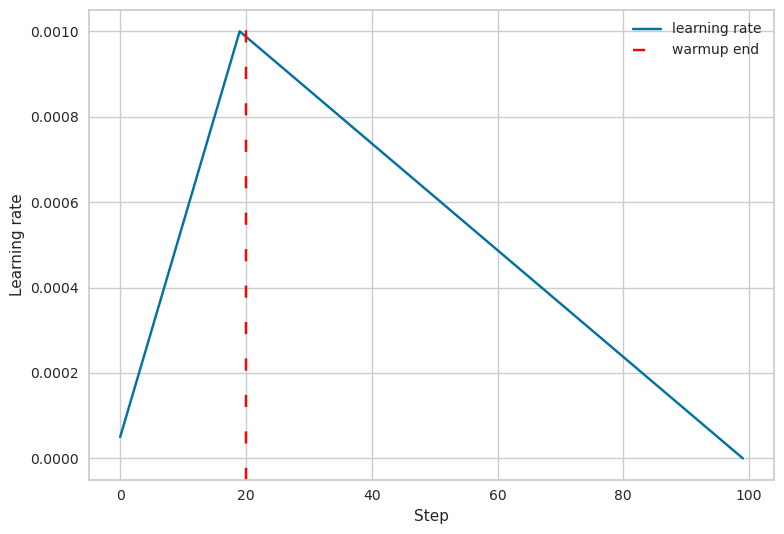

In [33]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [34]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [35]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(9984, 49920)

In [36]:
# Instance of the current model
model = RameauLabelTagger(
  n_classes=len(mlb.classes_),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# Evaluation
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.4970, 0.5503, 0.3813,  ..., 0.5141, 0.3403, 0.4972],
        [0.5473, 0.5302, 0.3347,  ..., 0.4783, 0.3499, 0.5152],
        [0.5462, 0.5262, 0.3389,  ..., 0.4684, 0.3586, 0.5131],
        ...,
        [0.5250, 0.5362, 0.3600,  ..., 0.4986, 0.3323, 0.5113],
        [0.5417, 0.5262, 0.3478,  ..., 0.4863, 0.3569, 0.5175],
        [0.5254, 0.5459, 0.3530,  ..., 0.5118, 0.3431, 0.5078]],
       grad_fn=<SigmoidBackward0>)

In [38]:
criterion = nn.BCELoss()
criterion(predictions, sample_batch["labels"])

tensor(0.7187, grad_fn=<BinaryCrossEntropyBackward0>)

In [39]:
checkpoint_callback = ModelCheckpoint(
  dirpath="./checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [40]:
logger = TensorBoardLogger("lightning_logs", name="Rameau")

In [41]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [42]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  devices=1,
  accelerator="gpu",
  enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(model, data_module)

/home/aurelie/anaconda3/envs/abes_index/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/aurelie/ABES/labo-indexationauto/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 16.4 M
2 | criterion  | BCELoss   | 0     
-----------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.988   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 7489/7489 [07:35<00:00, 16.45it/s, v_num=16, train_loss=0.00232, val_loss=0.00238]

Epoch 0, global step 7489: 'val_loss' reached 0.00238 (best 0.00238), saving model to '/home/aurelie/ABES/labo-indexationauto/checkpoints/best-checkpoint-v4.ckpt' as top 1


Epoch 1: 100%|██████████| 7489/7489 [07:46<00:00, 16.05it/s, v_num=16, train_loss=0.00124, val_loss=0.0012]  

Epoch 1, global step 14978: 'val_loss' reached 0.00120 (best 0.00120), saving model to '/home/aurelie/ABES/labo-indexationauto/checkpoints/best-checkpoint-v4.ckpt' as top 1


Epoch 2: 100%|██████████| 7489/7489 [07:51<00:00, 15.88it/s, v_num=16, train_loss=0.00168, val_loss=0.00113]

Epoch 2, global step 22467: 'val_loss' reached 0.00113 (best 0.00113), saving model to '/home/aurelie/ABES/labo-indexationauto/checkpoints/best-checkpoint-v4.ckpt' as top 1


: 

: 

In [ ]:
trainer.test()

In [ ]:
# Predictions
trained_model = RameauLabelTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(mlb.classes_)
)
trained_model.eval()
trained_model.freeze()

In [ ]:
# Evaluation
MAX_TOKEN_COUNT = 512


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = RameauLabelDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

## Metrics

In [ ]:
# Accuracy
THRESHOLD = 0.7
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
# AUROC
print("AUROC per tag")
for i, name in enumerate(mlb.classes_):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

In [ ]:
# Classification report
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=mlb.classes_,
  zero_division=0
))